# 【第３回　課題1　解答シート】 DeepDream
解答用のシートです．解答はこちらを改変して行って下さい．　

In [2]:
# UEC環境での初期設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0,..., "7":GPU7 を使用

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else:
    datadir="/usr/local/class/object/media/"
       
# 結果を出力するディレクトリを作成
outdir='result'
os.makedirs(outdir, exist_ok=True)

In [3]:
import keras

Using TensorFlow backend.


using GPU: 5


### 学習済みネットワークの選択

通常は，[ImageNet1000種類](./1000.txt)で事前学習されたネットワークを使います．前回利用したVGG16やResNet50でも可能ですが，ここではGoogleの開発した InceptionV3 を使ってみます．
初回はダウンロードが必要ですので，すこし時間がかかりますので，注意してください．

In [4]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

# model.summary()

In [18]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
  'mixed2': 0.2,
  'mixed3': 3.0,
  'mixed4': 2.0,
  'mixed5': 1.5,
  'mixed7': 4.0,
  'mixed9': 5.0
}

In [19]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [20]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [21]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = img.resize((640,480))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [22]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 50  # Number of ascent steps per scale  ### Gradient ascentの繰り返し回数．

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = 'img/turtle.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    # save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

#save_img(img, fname='final_dream.png')

Processing image shape (244, 326)
...Loss value at 0 : 1.9810197
...Loss value at 1 : 2.478751
...Loss value at 2 : 3.1106005
...Loss value at 3 : 3.6945157
...Loss value at 4 : 4.3471417
...Loss value at 5 : 4.934593
...Loss value at 6 : 5.481202
...Loss value at 7 : 6.098876
...Loss value at 8 : 6.62847
...Loss value at 9 : 7.1228795
...Loss value at 10 : 7.5897303
...Loss value at 11 : 8.050204
...Loss value at 12 : 8.476467
...Loss value at 13 : 8.841016
...Loss value at 14 : 9.458511
...Loss value at 15 : 9.8292265
Processing image shape (342, 457)
...Loss value at 0 : 2.9932232
...Loss value at 1 : 4.114751
...Loss value at 2 : 5.2004914
...Loss value at 3 : 6.1307
...Loss value at 4 : 6.7601485
...Loss value at 5 : 7.4437256
...Loss value at 6 : 8.076931
...Loss value at 7 : 8.531863
...Loss value at 8 : 9.078338
...Loss value at 9 : 9.543128
Processing image shape (480, 640)
...Loss value at 0 : 3.0596535
...Loss value at 1 : 4.1725383
...Loss value at 2 : 5.1548386
...Loss val

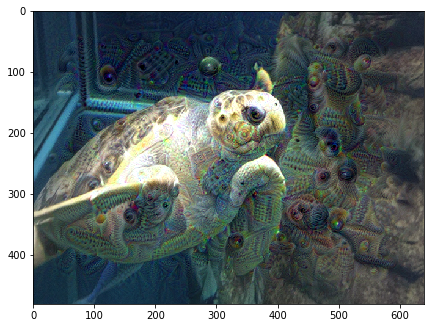

In [23]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

plt.figure(figsize=(7, 7))
out=deprocess_image(np.copy(img))
plt.imshow(out)
plt.show()

Image.fromarray(out).save(outdir+'/final_dream7.png')

## 課題1
以下の小問の(1)-(2)を解答せよ．

1. 上記のライオン画像以外の任意の画像2枚について変換してみよ．
1. mixed2からmixed5までを強調しているが，その割合を変えるとどうなるか試してみよ．例えば，mixed2とmixed3だけにしてみよ．

コードをコピーするのは大変なので，パラメータを変えて実行する毎に，出力ファイル名を変えて，
この設問の後に，適宜セルを追加して，Markdownで回答せよ．

 !［］(result/final_dream1.png) 
 
 もしくは
 
 &lt;img src="result/final_dream2.png" width="320">　　(こちらはサイズ指定可能)
 
と記述して，結果の画像を挿入しつつ，どのような設定で実行したか，得られた結果に対する考察など簡単な説明もつけよ．

# (1)上記のライオン画像以外の任意の画像2枚について変換してみよ．

Processing image shape (244, 326)
...Loss value at 0 : 1.4941106
...Loss value at 1 : 2.1394541
...Loss value at 2 : 2.7916553
...Loss value at 3 : 3.5049024
...Loss value at 4 : 4.159745
...Loss value at 5 : 4.8268423
...Loss value at 6 : 5.4921694
...Loss value at 7 : 6.0849
...Loss value at 8 : 6.7023067
...Loss value at 9 : 7.3190837
...Loss value at 10 : 7.895762
...Loss value at 11 : 8.477968
...Loss value at 12 : 9.045685
...Loss value at 13 : 9.542125
Processing image shape (342, 457)
...Loss value at 0 : 2.6699014
...Loss value at 1 : 3.9096694
...Loss value at 2 : 4.9222364
...Loss value at 3 : 5.827635
...Loss value at 4 : 6.6665325
...Loss value at 5 : 7.4876094
...Loss value at 6 : 8.220089
...Loss value at 7 : 8.928116
...Loss value at 8 : 9.626869
Processing image shape (480, 640)
...Loss value at 0 : 2.8000479
...Loss value at 1 : 3.9343188
...Loss value at 2 : 4.9773273
...Loss value at 3 : 5.9739947
...Loss value at 4 : 7.0362086
...Loss value at 5 : 8.293926
...Loss 

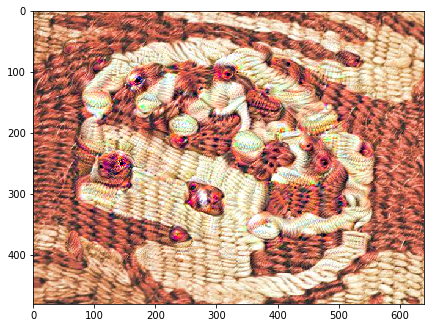

In [12]:
import numpy as np

step = 0.01  
num_octave = 3  
octave_scale = 1.4 
iterations = 50  

max_loss = 10.

base_image_path = datadir+'/material10/fabric/fabric_moderate_001_new.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
   
plt.figure(figsize=(7, 7))
out=deprocess_image(np.copy(img))
plt.imshow(out)
plt.show()

Image.fromarray(out).save(outdir+'/final_dream2.png')

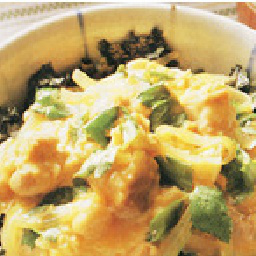

In [9]:
import IPython.display as display
from PIL import Image
display.display(Image.open('/usr/local/class/object/media//uecfood20/oyakodon/308.jpg'))


Processing image shape (244, 326)
...Loss value at 0 : 1.5489664
...Loss value at 1 : 2.0591977
...Loss value at 2 : 2.728536
...Loss value at 3 : 3.420541
...Loss value at 4 : 4.1387405
...Loss value at 5 : 4.917847
...Loss value at 6 : 5.601194
...Loss value at 7 : 6.282751
...Loss value at 8 : 6.833103
...Loss value at 9 : 7.5055437
...Loss value at 10 : 8.052912
...Loss value at 11 : 8.607548
...Loss value at 12 : 9.167455
...Loss value at 13 : 9.641532
Processing image shape (342, 457)
...Loss value at 0 : 3.0360568
...Loss value at 1 : 4.3076982
...Loss value at 2 : 5.309177
...Loss value at 3 : 6.1662526
...Loss value at 4 : 6.994508
...Loss value at 5 : 7.7346478
...Loss value at 6 : 8.44194
...Loss value at 7 : 9.109742
...Loss value at 8 : 9.69771
Processing image shape (480, 640)
...Loss value at 0 : 3.2346418
...Loss value at 1 : 4.4177027
...Loss value at 2 : 5.4519787
...Loss value at 3 : 6.3729806
...Loss value at 4 : 7.280031
...Loss value at 5 : 8.107733
...Loss value 

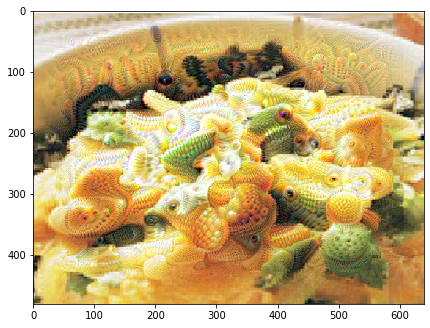

In [13]:
import numpy as np

step = 0.01 
num_octave = 3  
octave_scale = 1.4  
iterations = 50 

max_loss = 10.

base_image_path = datadir+'/uecfood20/oyakodon/308.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

plt.figure(figsize=(7, 7))
out=deprocess_image(np.copy(img))
plt.imshow(out)
plt.show()

Image.fromarray(out).save(outdir+'/final_dream3.png')

# コメント
おそらく白い糸による模様の端にdreamが発生している。繊維の加工後の画像をみてみると、模様が人の顔のように見えてきた。元々この模様は人の顔だったのだとさえ思えてきた。親子丼がまるで海鮮丼のように見えるようになった。最初に亀の画像とライオンの画像の処理結果をみた時は、目玉が複数画面に生成されてあるいは現代アートのような、若干気持ち悪く感じるような画像になるのかと思っていたが、もう一つの模様の画像でも違和感のない画像になっていたのでこちらが通常なのかもしれないと思うようになった。また、基本的に第二回で行ったヒートマップの位置(画像の判定に使われる領域)にはdreamができていることに気づいた。これは、dreamが少しでも○○っぽいものをより○○っぽくするというものであることによるものであると考えられる。つまり、そこが画像認識に使えるほど特徴的であるから、より特徴的になったのだと考えられる。

# (2)mixed2からmixed5までを強調しているが，その割合を変えるとどうなるか試してみよ．例えば，mixed2とmixed3だけにしてみよ

# 元のmixed設定の画像(ライオン)
<img src="result/final_dream1.png" width="960">

# mixed3:3.0,mixed4:2.0

<img src="result/final_dream4.png" width="960">

# 元のmixed設定の画像(カメ)

<img src="result/final_dream5.png" width="960">

# mixed2: 0.2,mixed3: 3.0,mixed4: 2.0,mixed5: 1.5,mixed7: 1.0,mixed9: 1.0

<img src="result/final_dream6.png" width="960">

# mixed2: 0.2,mixed3: 3.0,mixed4: 2.0,mixed5: 1.5,mixed7: 4.0,mixed9: 5.0

<img src="result/final_dream7.png" width="960">

# コメント
変換後の方が、mixedの値や数に関わらず、目(穴)が増えていた。最初、mixedの数を増やすほどmixedの数が増えるのかと思っていたが結果を見る限りではそういうことでもないということがわかった。これは、レイヤーごとに認識信号の出ている部分がかぶることがあるためであると考えられる。あと、亀の口の部分と背景の境目が曖昧になっていた。逆に、変換後にはヒートマップの二番目の候補の位置(亀の甲羅のてっぺんの位置)に目玉がなくっていた。ただ、全体的に何が変わっているのかよくわからない程度の変化だった。課題を通して亀だけ元の絵に少し追加したような絵になっている。これは、亀の絵が全体的に似た色で構成されていることが原因であると考えられる。あと、(1)の時点では気づかなかったが、画像の上下左右1/8に一切加工が加えられていないことに気づいた。これは、おそらくではあるが、画像認識するには画像の端では情報が足りないことがあるためであると考えられる。

In [ ]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()